In [1]:
import random
import numpy as np

import torch
import torch as th
import torch.nn as nn
from torch import Tensor

/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# Notebook support or argpase
import sys; sys.argv=['']; del sys

# General config related
from configurator import get_arg_dict, generate_args

# Env config related
from ss_baselines.av_nav.config import get_config
from ss_baselines.savi.config.default import get_config as get_savi_config
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class

# region: Generating additional hyparams
CUSTOM_ARGS = [
    # General hyper parameters
    get_arg_dict("seed", int, 111),
    get_arg_dict("total-steps", int, 1_000_000),

    # SS env config
    get_arg_dict("config-path", str, "env_configs/audiogoal_rgb_nocont.yaml"),

    # PPO Hyper parameters
    get_arg_dict("num-envs", int, 1), # Number of parallel envs. 10 by default
    get_arg_dict("num-steps", int, 150), # For each env, how many steps are collected to form PPO Agent rollout.
    get_arg_dict("num-minibatches", int, 1), # Number of mini-batches the rollout data is split into to make the updates
    get_arg_dict("update-epochs", int, 4), # Number of gradient step for the policy and value networks
    get_arg_dict("gamma", float, 0.99),
    get_arg_dict("gae-lambda", float, 0.95),
    get_arg_dict("norm-adv", bool, True, metatype="bool"),
    get_arg_dict("clip-coef", float, 0.1), # Surrogate loss clipping coefficient
    get_arg_dict("clip-vloss", bool, True, metatype="bool"),
    get_arg_dict("ent-coef", float, 0.2), # Entropy loss coef; 0.2 in SS baselines
    get_arg_dict("vf-coef", float, 0.5), # Value loss coefficient
    get_arg_dict("max-grad-norm", float, 0.5),
    get_arg_dict("target-kl", float, None),
    get_arg_dict("lr", float, 2.5e-4), # Learning rate
    get_arg_dict("optim-wd", float, 0), # weight decay for adam optim
    ## Agent network params
    get_arg_dict("agent-type", str, "ss-default", metatype="choice",
        choices=["ss-default", "deep-etho",
                    "perceiver-gwt-gwwm", "perceiver-gwt-attgru"]),
    get_arg_dict("hidden-size", int, 512), # Size of the visual / audio features and RNN hidden states 
    ## Perceiver / PerceiverIO params: TODO: num_latnets, latent_dim, etc...
    get_arg_dict("pgwt-latent-type", str, "randn", metatype="choice",
        choices=["randn", "zeros"]), # Depth of the Perceiver
    get_arg_dict("pgwt-latent-learned", bool, True, metatype="bool"),
    get_arg_dict("pgwt-depth", int, 1), # Depth of the Perceiver
    get_arg_dict("pgwt-num-latents", int, 8),
    get_arg_dict("pgwt-latent-dim", int, 64),
    get_arg_dict("pgwt-cross-heads", int, 1),
    get_arg_dict("pgwt-latent-heads", int, 4),
    get_arg_dict("pgwt-cross-dim-head", int, 64),
    get_arg_dict("pgwt-latent-dim-head", int, 64),
    get_arg_dict("pgwt-weight-tie-layers", bool, False, metatype="bool"),
    get_arg_dict("pgwt-ff", bool, False, metatype="bool"),
    get_arg_dict("pgwt-num-freq-bands", int, 6),
    get_arg_dict("pgwt-max-freq", int, 10.),
    get_arg_dict("pgwt-use-sa", bool, False, metatype="bool"),
    ## Peceiver Modality Embedding related
    get_arg_dict("pgwt-mod-embed", int, 0), # Learnable modality embeddings
    ## Additional modalities
    get_arg_dict("pgwt-ca-prev-latents", bool, True, metatype="bool"), # if True, passes the prev latent to CA as KV input data

    # Logging params
    # NOTE: While supported, video logging is expensive because the RGB generation in the
    # envs hogs a lot of GPU, especially with multiple envs 
    get_arg_dict("save-videos", bool, False, metatype="bool"),
    get_arg_dict("save-model", bool, True, metatype="bool"),
    get_arg_dict("log-sampling-stats-every", int, int(1.5e3)), # Every X frames || steps sampled
    get_arg_dict("log-training-stats-every", int, int(10)), # Every X model update
    get_arg_dict("logdir-prefix", str, "./logs/") # Overrides the default one
]
args = generate_args(CUSTOM_ARGS)

# Additional PPO overrides
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)


In [ ]:

# Load environment config
is_SAVi = str.__contains__(args.config_path, "savi")
if is_SAVi:
    env_config = get_savi_config(config_paths=args.config_path)
else:
    env_config = get_config(config_paths=args.config_path)
# endregion: Generating additional hyparams

# Overriding some envs parametes from the .yaml env config
env_config.defrost()
env_config.NUM_PROCESSES = 1 # Corresponds to number of envs, makes script startup faster for debugs
env_config.USE_SYNC_VECENV = True
# env_config.USE_VECENV = False
# env_config.CONTINUOUS = args.env_continuous
## In caes video saving is enabled, make sure there is also the rgb videos
env_config.freeze()
# print(env_config)

# Environment instantiation
envs = construct_envs(env_config, get_env_class(env_config.ENV_NAME))
single_observation_space = envs.observation_spaces[0]
single_action_space = envs.action_spaces[0]

single_observation_space, single_action_space

In [23]:
# TODO seeding for reproducibility ? Make sure that we can control the generated episode trajs ?

# Loading pretrained agent
import models
from models import ActorCritic, Perceiver_GWT_GWWM_ActorCritic
## PPO GRU agent working with RGB observations
ppo_gru_agent_state_dict = th.load("/home/rousslan/random/rl/exp-logs/ss-hab/ppo_av_nav__ss1_rgb_spectro_seed_111__2022_09_06_13_59_13_931240.musashi/models/ppo_agent.994501.ckpt.pth")
ppo_gru_agent = ActorCritic(single_observation_space, single_action_space, args.hidden_size, extra_rgb=False,
    analysis_layers=models.GRU_ACTOR_CRITIC_DEFAULT_ANALYSIS_LAYER_NAMES)
ppo_gru_agent.eval()
ppo_gru_agent.load_state_dict(ppo_gru_agent_state_dict)

## PPO PGWT working with RGB observations
ppo_pgwt_agent_state_dict = th.load("/home/rousslan/random/rl/exp-logs/ss-hab/ppo_av_nav__ss1_rgb_spectro__pgwt_gwwm__dpth_1_nlats_8_latdim_64_noSA_CAnheads_1_SAnheads_4_modembed_0_CAprevlats_seed_111__2022_09_06_14_43_49_094181.musashi/models/ppo_agent.993001.ckpt.pth")
ppo_pgwt_agent = Perceiver_GWT_GWWM_ActorCritic(single_observation_space, single_action_space, args, extra_rgb=False,
    analysis_layers=models.PGWT_GWWM_ACTOR_CRITIC_DEFAULT_ANALYSIS_LAYER_NAMES)
ppo_pgwt_agent.eval()
ppo_pgwt_agent.load_state_dict(ppo_pgwt_agent_state_dict)

<All keys matched successfully>

In [110]:

# Collecting episode data
## Helper
dev = th.device("cpu")
def tensorize_obs_dict(obs, device, observations=None, rollout_step=None):
    obs_th = {}
    for obs_field, _ in obs[0].items():
        v_th = th.Tensor(np.array([step_obs[obs_field] for step_obs in obs], dtype=np.float32)).to(device)
        # in SS1.0, the dcepth observations comes as [B, 128, 128, 1, 1], so fix that
        if obs_field == "depth" and v_th.dim() == 5:
            v_th = v_th.squeeze(-1)
        obs_th[obs_field] = v_th
        # Special case when doing the rollout, also stores the 
        if observations is not None:
            observations[obs_field][rollout_step] = v_th
    
    return obs_th

obs_list, reward_list, done_list, info_list, action_list = [], [], [], [], []
obs_th_list, done_th_list = [], [] 

rnn_hidden_state = th.zeros((1, args.num_envs, args.hidden_size), device=dev)

obs, done = envs.reset(), [False for _ in range(args.num_envs)]
done_th = th.Tensor(done).to(dev)
masks = 1. - done_th[:, None]

while not done_th.sum():
    obs_th = tensorize_obs_dict(obs, dev)
    done_th = th.Tensor(done).to(dev)
    with th.no_grad():
        action, action_logprobs, _, value, rnn_hidden_state = \
            ppo_gru_agent.act(obs_th, rnn_hidden_state, masks=masks)
    
    outputs = envs.step([a[0].item() for a in action])
    next_obs, reward, next_done, info = [list(x) for x in zip(*outputs)]

    # NOTE obs_list and done_list would have one extra position than info_list
    obs_list.append(obs)
    done_list.append(done)
    obs_th_list.append(obs_th)
    done_th_list.append(done_th)

    reward_list.append(reward)
    info_list.append(info)
    action_list.append(action.cpu().numpy())

    # Prepare for the next step
    obs = next_obs
    done = next_done

    # DEBUG: producing shorter sequence for downstream tests
    if len(obs_list) >= 100:
        break

len(obs_list) # Episode length

46

In [111]:
# Feed a given trajectory to each agent type, and collect the intermediate features of the network at each step
ppo_gru_analysis_feats__raw = {}
ppo_pgwt_analysis_feats__raw = {}

# Resets the rnn_hidden_states for each agent
gru_rnn_hidden_state = th.zeros((1, args.num_envs, args.hidden_size), device=dev)
pgwt_rnn_hidden_state = ppo_pgwt_agent.state_encoder.latents.clone()
gru_rnn_hidden_state.shape, pgwt_rnn_hidden_state.shape

for t, (obs_th, done_th) in enumerate(zip(obs_th_list, done_th_list)):
    # Feeding the same sequence of observatiosn to each type of agent
    masks = 1. - done_th[:, None]
    with th.no_grad():
        # NOTE: rnn_hidden_state or pgwt's latent are already collected in "state_encoder" field in _features
        _, _, _, _, rnn_hidden_state = ppo_gru_agent.act(obs_th, rnn_hidden_state, masks)
        _, _, _, _, pgwt_rnn_hidden_state = ppo_pgwt_agent.act(obs_th, pgwt_rnn_hidden_state, masks)


    # Collecting intermediate layer results
    ## PPO GRU
    for k,v in ppo_gru_agent._features.items():
        if k not in list(ppo_gru_analysis_feats__raw.keys()):
            ppo_gru_analysis_feats__raw[k] = []
        ppo_gru_analysis_feats__raw[k].append(v)
    
    ## PPO PGWT
    for k, v in ppo_pgwt_agent._features.items():
        if k not in list(ppo_pgwt_analysis_feats__raw.keys()):
            ppo_pgwt_analysis_feats__raw[k] = []
        ppo_pgwt_analysis_feats__raw[k].append(v)

# TODO: additioanl processing to make it nicely organized tensors
## NOTE: there are some keys that will have tuple of shape 2 or 3, need to take account for that
ppo_gru_analysis_feats = {}
ppo_pgwt_analysis_feats = {}

def process_analysis_feats_raw(raw_dict):
    result_dict = {}

    for k, v in raw_dict.items():
        if isinstance(v[0], th.Tensor):
            new_v = th.cat(v, dim=0)
        elif isinstance(v[0], tuple):
            new_v = None # TODO
            n_elements = len(v[0])
            elements = [[] for _ in range(n_elements)]
            for j in range(n_elements):
                for i in range(len(v)):
                    elements[j].append(v[i][j])
            
            new_v = [th.cat(vv, dim=0) for vv in elements]
        else:
            raise Exception(f"Unhandled type: {v[0].__class__}")
    
        result_dict[k] = new_v
    
    return result_dict
    
ppo_gru_analysis_feats = process_analysis_feats_raw(ppo_gru_analysis_feats__raw)
ppo_pgwt_analysis_feats = process_analysis_feats_raw(ppo_pgwt_analysis_feats__raw)

In [112]:
list(ppo_gru_analysis_feats.keys())

ppo_gru_analysis_feats["state_encoder"][0].shape, ppo_gru_analysis_feats["state_encoder"][1].shape
ppo_pgwt_analysis_feats["state_encoder"][0].shape, ppo_pgwt_analysis_feats["state_encoder"][1].shape

ppo_gru_analysis_feats["state_encoder"][0].shape, ppo_pgwt_analysis_feats["state_encoder"][0].shape

ppo_gru_analysis_feats["visual_encoder.cnn.0"][0].shape, ppo_pgwt_analysis_feats["visual_encoder.cnn.0"][0].shape
ppo_gru_analysis_feats["visual_encoder.cnn.1"][0].shape, ppo_pgwt_analysis_feats["visual_encoder.cnn.1"][0].shape
# list(ppo_gru_analysis_feats__raw.keys())

# len(ppo_gru_analysis_feats__raw["state_encoder"]), len(ppo_gru_analysis_feats__raw["state_encoder"][0])
# ppo_gru_analysis_feats["critic.fc"].shape
# th.cat(ppo_gru_analysis_feats["critic.fc"], dim=0).shape # [T, ...]

# ppo_gru_analysis_feats["visual_encoder.cnn.0"].shape
# th.cat(ppo_gru_analysis_feats["visual_encoder.cnn.0"], dim=0).shape # [T, ...]

(torch.Size([32, 31, 31]), torch.Size([32, 31, 31]))

((<Figure size 500x500 with 1 Axes>,
  array([[<AxesSubplot:>]], dtype=object),
  defaultdict(dict,
              {<AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f41352ace80>}})),
 (<Figure size 500x500 with 1 Axes>,
  array([[<AxesSubplot:>]], dtype=object),
  defaultdict(dict,
              {<AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f4134951e50>}})))

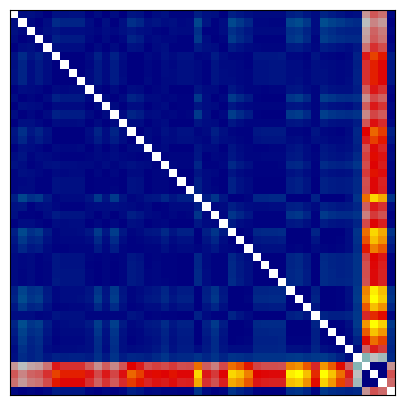

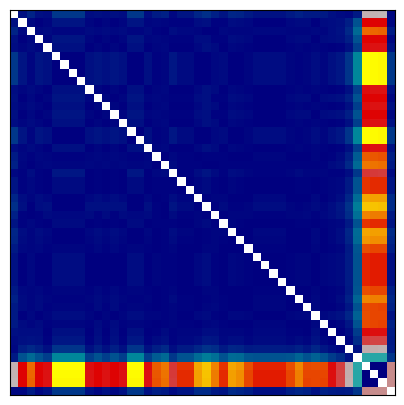

In [124]:
# Basic RSA Toolbox usage
import rsatoolbox

# ppo_gru_data = rsatoolbox.data.Dataset(ppo_gru_analysis_feats["visual_encoder.cnn.0"].flatten(start_dim=1).cpu().numpy())
# ppo_pgwt_data = rsatoolbox.data.Dataset(ppo_pgwt_analysis_feats["visual_encoder.cnn.0"].flatten(start_dim=1).cpu().numpy())

# ppo_gru_data = rsatoolbox.data.Dataset(ppo_gru_analysis_feats["visual_encoder.cnn.7"].flatten(start_dim=1).cpu().numpy())
# ppo_pgwt_data = rsatoolbox.data.Dataset(ppo_pgwt_analysis_feats["visual_encoder.cnn.7"].flatten(start_dim=1).cpu().numpy())

# ppo_gru_data = rsatoolbox.data.Dataset(ppo_gru_analysis_feats["state_encoder"][0].flatten(start_dim=1).cpu().numpy())
# ppo_pgwt_data = rsatoolbox.data.Dataset(ppo_pgwt_analysis_feats["state_encoder"][0].flatten(start_dim=1).cpu().numpy())

# ppo_gru_data = rsatoolbox.data.Dataset(ppo_gru_analysis_feats["critic.fc"].flatten(start_dim=1).cpu().numpy())
# ppo_pgwt_data = rsatoolbox.data.Dataset(ppo_pgwt_analysis_feats["critic.fc"].flatten(start_dim=1).cpu().numpy())

ppo_gru_data = rsatoolbox.data.Dataset(ppo_gru_analysis_feats["action_distribution.linear"].flatten(start_dim=1).cpu().numpy())
ppo_pgwt_data = rsatoolbox.data.Dataset(ppo_pgwt_analysis_feats["action_distribution.linear"].flatten(start_dim=1).cpu().numpy())

ppo_gru_rdms = rsatoolbox.rdm.calc_rdm(ppo_gru_data)
ppo_pgwt_rdms = rsatoolbox.rdm.calc_rdm(ppo_pgwt_data)

rsatoolbox.vis.show_rdm(ppo_gru_rdms, figsize=(5,5)), rsatoolbox.vis.show_rdm(ppo_pgwt_rdms, figsize=(5,5))

In [16]:
# Generating video with audio from the sampled episode
from ss_baselines.common.utils import images_to_video_with_audio, plot_top_down_map

video_data = {
    "rgb": [obs[0]["rgb"] for obs in obs_list],
    "audiogoal": [obs[0]["audiogoal"] for obs in obs_list]
}
video_dir_path = "/tmp"
video_filename = "episode_video"

# Save video to file
images_to_video_with_audio(
    images=video_data["rgb"],
    audios=video_data["audiogoal"],
    output_dir=video_dir_path,
    video_name=video_filename,
    sr=env_config.TASK_CONFIG.SIMULATOR.AUDIO.RIR_SAMPLING_RATE, # 16000 for mp3d dataset
    fps=1 # Default seems to be 10 though
)

chunk:  19%|█▊        | 2070/11048 [06:59<00:36, 243.28it/s, now=None]

Moviepy - Building video /tmp/episode_video.mp4.
MoviePy - Writing audio in episode_videoTEMP_MPY_wvf_snd.mp3


chunk:  19%|█▊        | 2070/11048 [07:06<00:36, 243.28it/s, now=None]

MoviePy - Done.
Moviepy - Writing video /tmp/episode_video.mp4



chunk:  19%|█▊        | 2070/11048 [07:07<00:36, 243.28it/s, now=None]

Moviepy - Done !
Moviepy - video ready /tmp/episode_video.mp4


In [5]:
from ss_baselines.common.utils import plot_top_down_map

info_list[0]
# plot_top_down_map(info_list[0])

[{'distance_to_goal': 12.0,
  'normalized_distance_to_goal': 1.0,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.0,
  'na': 1,
  'sna': 0.0}]